Does the number of hidden nodes and layers affect the performance of backpropagation learning?

In [1]:
using CSV, DataFrames, Random, Plots, Statistics, MLDataUtils, Flux, Dates

In [2]:
data = CSV.read("kc_house_data.csv", DataFrame)
data = select(data, Not([:id, :date]))
function min_max_scale!(df::DataFrame)
    for col in names(df)
        min_val = minimum(df[!, col])
        max_val = maximum(df[!, col])
        df[!, col] = (df[!, col] .- min_val) / (max_val - min_val)
    end
    return df
end
min_max_scale!(data)
train_data, test_data = splitobs(data, at = 0.7)
trainX, trainY = train_data[!, Not(:price)], train_data[!, :price]
testX, testY = test_data[!, Not(:price)], test_data[!, :price]
trainX, trainY, testX, testY = Matrix{Float64}(trainX), Vector{Float64}(trainY), Matrix{Float64}(testX), Vector{Float64}(testY)
trainData = []
for i in range(start=1, stop=size(trainX, 1), step=1)
    push!(trainData, (trainX[i, :], [trainY[i]]))
end
testData = []
for i in range(start=1, stop=size(testX, 1), step=1)
    push!(testData, (testX[i, :], [testY[i]]))
end

In [13]:
model = Chain(
    Dense(18, 18, relu),
    Dense(18, 1)
)

loss(x, y) = Flux.Losses.mse(model(x), y)

opt = ADAM()

function train!(model, data, opt, loss)
    prev_loss = Inf
    count = 0
    threshold=0.00001
    patience=10
    start = time()
    current_loss = 0
    for epoch in 1:1000 
        Flux.train!(loss, Flux.params(model), data, opt)
        
        current_loss = mean([loss(x, y) for (x, y) in data])
        # println(current_loss)

        if abs(prev_loss - current_loss) < threshold && epoch >= 100
            count += 1
            if count >= patience
                println("Training stopped after $epoch epochs.")
                break
            end
        else
            count = 0
        end

        prev_loss = current_loss
    end
    finish = time()

    return (finish - start), current_loss
end

timeTaken, E1 = train!(model, trainData, opt, loss)

Training stopped after 137 epochs.


(38.078197956085205, 0.0003485968519507065)

In [14]:
function architectures(num)
    if num == 1
        model = Chain(
                Dense(18, 2*18, relu),
                Dense(2*18, 1)
                )
        return model

    elseif num == 2
        model = Chain(
                Dense(18, 3*18, relu),
                Dense(3*18, 1)
                )
        return model

    elseif num == 3
        model = Chain(
                Dense(18, 4*18, relu),
                Dense(4*18, 1)
                )
        return model

    elseif num == 4
        model = Chain(
                Dense(18, 5*18, relu),
                Dense(5*18, 1)
                )
        return model

    elseif num == 5
        model = Chain(
                Dense(18, 6*18, relu),
                Dense(6*18, 1)
                )
        return model
    elseif num == 6
        model = Chain(
                Dense(18, 18, relu),
                Dense(18, 18, relu),
                Dense(18, 1)
                )
        return model
    elseif num == 7
        model = Chain(
                Dense(18, 18, relu),
                Dense(18, 18, relu),
                Dense(18, 18, relu),
                Dense(18, 1)
                )
        return model
    elseif num == 8
        model = Chain(
                Dense(18, 18, relu),
                Dense(18, 18, relu),
                Dense(18, 18, relu),
                Dense(18, 18, relu),
                Dense(18, 1)
                )
        return model
    elseif num == 9
        model = Chain(
                Dense(18, 18, relu),
                Dense(18, 18, relu),
                Dense(18, 18, relu),
                Dense(18, 18, relu),
                Dense(18, 18, relu),
                Dense(18, 1)
                )
        return model
    elseif num == 10
        model = Chain(
                Dense(18, 18, relu),
                Dense(18, 18, relu),
                Dense(18, 18, relu),
                Dense(18, 18, relu),
                Dense(18, 18, relu),
                Dense(18, 18, relu),
                Dense(18, 1)
                )
        return model
    else
        return nothing
    end
end

architectures (generic function with 1 method)

In [15]:
function train!(model, data, testData, opt, loss, E1)
    start = time()
    current_loss = 0
    wtUpdates = 0
    numParams = 0
    params = collect(Flux.params(model))
    for param in params
        s = size(param)
        try
            numParams += s[1] * s[2]
        catch BoundsError
            numParams += s[1]
        end
    end
    for epoch in 1:1000 
        Flux.train!(loss, Flux.params(model), data, opt)
        wtUpdates += numParams
        current_loss = mean([loss(x, y) for (x, y) in data])

        if current_loss < E1
            println("Training stopped after $epoch epochs.")
            break
        end
    end
    finish = time()
    testLoss = mean([loss(x, y) for (x, y) in testData])
    return (finish - start), testLoss, log(wtUpdates)
end

train! (generic function with 2 methods)

In [17]:
exp_times, exp_testLosses, exp_wtUpdates = [], [], []
for exp in 1:10
    println("Experiment $exp")
    model = architectures(exp)
    time, testLoss, wtUpdates = train!(model, trainData, testData, opt, loss, E1)
    push!(exp_times, time)
    push!(exp_testLosses, testLoss)
    push!(exp_wtUpdates, wtUpdates)
end

Experiment 1


Training stopped after 60 epochs.
Experiment 2


Training stopped after 105 epochs.
Experiment 3


Training stopped after 25 epochs.
Experiment 4


Training stopped after 21 epochs.
Experiment 5


Experiment 6


Training stopped after 14 epochs.
Experiment 7


Training stopped after 35 epochs.
Experiment 8


Training stopped after 27 epochs.
Experiment 9


Training stopped after 10 epochs.
Experiment 10


Training stopped after 38 epochs.


In [18]:
exp_times

10-element Vector{Any}:
  18.334053993225098
  39.521613121032715
   9.816501140594482
   9.233702898025513
 871.7550709247589
   5.8752830028533936
  16.282512187957764
  18.761932134628296
   8.138046979904175
  28.867645025253296

In [25]:
exp_testLosses

10-element Vector{Any}:
 0.00042967823762261734
 0.00042767843724007956
 0.00042459671234039854
 0.0004149910567738543
 0.0004159576201538058
 0.0004069467834069091
 0.0003676709071880781
 0.0003781057072374768
 0.0003907914846604832
 0.00040587889408874405

In [20]:
exp_wtUpdates

10-element Vector{Any}:
 10.67498369950705
 11.639602167796731
 10.491968420867723
 10.540619782899379
 14.586081635489023
  9.194414221425923
 10.507120225888325
 10.53073528631916
  9.757883578677337
 11.27337302112197

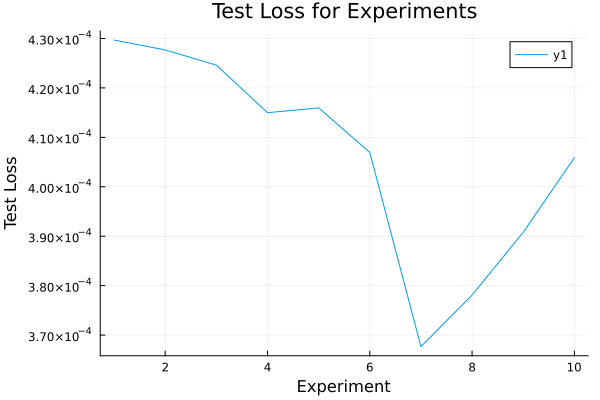

In [21]:
plot(1:10, exp_testLosses, title = "Test Loss for Experiments", xlabel="Experiment", ylabel="Test Loss")

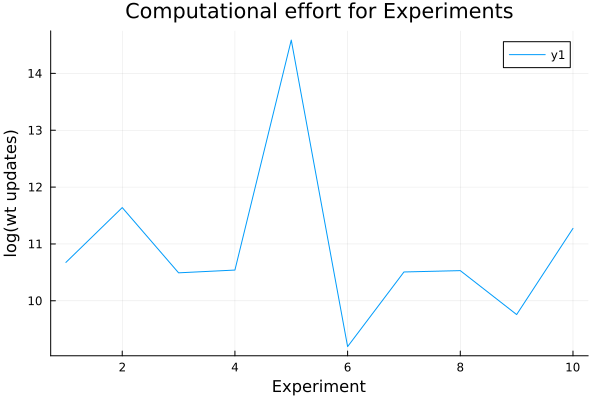

In [22]:
plot(1:10, exp_wtUpdates, title = "Computational effort for Experiments", xlabel="Experiment", ylabel="log(wt updates)")

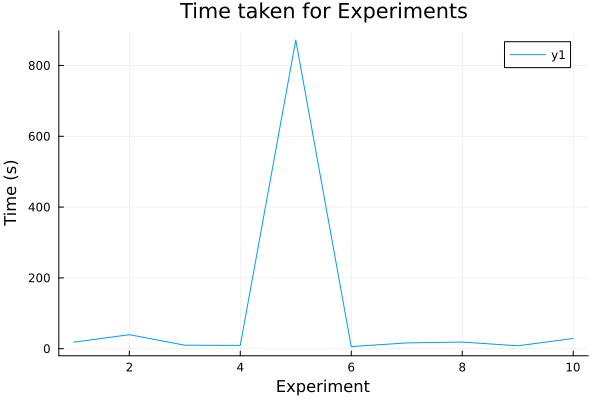

In [23]:
plot(1:10, exp_times, title = "Time taken for Experiments", xlabel="Experiment", ylabel="Time (s)")